#Brazilian soccer matches outcome prediction

Yes, we are going to try it

#1) Install and load prerequisites


We will install pyspark from scrach for systems were it is not part of the runtime

In [1]:
!apt update -qq
!apt install openjdk-8-jdk-headless -qq > /dev/null

!wget -Nq https://archive.apache.org/dist/spark/spark-3.5.1/spark-3.5.1-bin-hadoop3.tgz
!tar xf spark-3.5.1-bin-hadoop3.tgz

!pip install findspark
!pip install pyspark
!pip install py4j

50 packages can be upgraded. Run 'apt list --upgradable' to see them.
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)




Here, most of the modules used in this notebook are loaded

In [2]:
# configurar as variáveis de ambiente
import os
import sys
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.5.1-bin-hadoop3"

import findspark
#findspark.init('spark-3.5.1-bin-hadoop3')
findspark.init()
findspark.find()


'/content/spark-3.5.1-bin-hadoop3'

In [3]:
from pyspark import SparkContext
from pyspark import SparkConf
from pyspark.sql import SQLContext, SparkSession
from pyspark.sql.types import StructType, StructField, DoubleType, IntegerType, StringType
from pyspark.sql.functions import lit, date_format, when, col
from pyspark.sql.functions import udf
from pyspark.sql.functions import percentile_approx
from pyspark.sql.functions import dayofweek, year, dayofmonth, month, to_date
from pyspark.sql.functions import hour, minute

from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorIndexer
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.linalg import Vectors, VectorUDT

from pyspark.ml.classification import MultilayerPerceptronClassifier
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.classification import NaiveBayes
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.classification import OneVsRest
from pyspark.ml.classification import LinearSVC
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics

from collections import defaultdict
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random

In [4]:
sc = SparkContext.getOrCreate(SparkConf().setMaster("local[*]"))

spark = SparkSession.builder.getOrCreate()

#2) Load and Explore data

This is a dataset containing results of soccer matches from 2003 to 2023 editions of the Brazlian national soccer championship

Source: https://www.kaggle.com/datasets/adaoduque/campeonato-brasileiro-de-futebol/

In [5]:
#https://www.kaggle.com/datasets/adaoduque/campeonato-brasileiro-de-futebol/

!wget -Nq 'https://raw.githubusercontent.com/adaoduque/Brasileirao_Dataset/master/campeonato-brasileiro-full.csv'

path_brt_full = 'campeonato-brasileiro-full.csv'
df_brt_full = spark.read.csv(path_brt_full, inferSchema=True, header=True)

# These columns identify were features and target are located
target_col = 'result'
features_cols = []
features_vec_col = 'features'

Let's see all the columns we have:

In [6]:
print(*list(df_brt_full.columns), sep='\n')

ID
rodata
data
hora
mandante
visitante
formacao_mandante
formacao_visitante
tecnico_mandante
tecnico_visitante
vencedor
arena
mandante_Placar
visitante_Placar
mandante_Estado
visitante_Estado


##2.1) Home and away teams

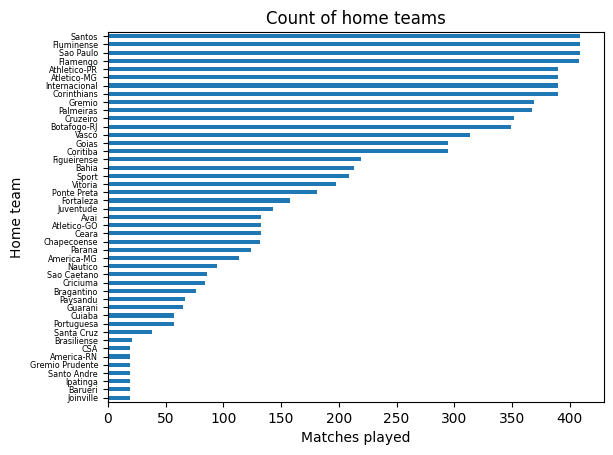

In [7]:
df_tmp = df_brt_full.groupby("mandante").count().toPandas().sort_values('count', ascending=True)

df_tmp.plot.barh(x='mandante', y='count', legend=False)

plt.ylabel('Home team')
plt.xlabel('Matches played')
plt.title('Count of home teams')

plt.yticks(fontsize = 'xx-small')

plt.show()

Since every team plays against each other exactly two times in one season (at home and away), this graph is the same if we counted the Away Team column values


##2.2) Team formation

<ipython-input-8-b2dad573f18d>:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[0].set_xticklabels(df_tmp_full['formacao'], rotation=90)
<ipython-input-8-b2dad573f18d>:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[1].set_xticklabels(df_tmp_partial['formacao'], rotation=90)


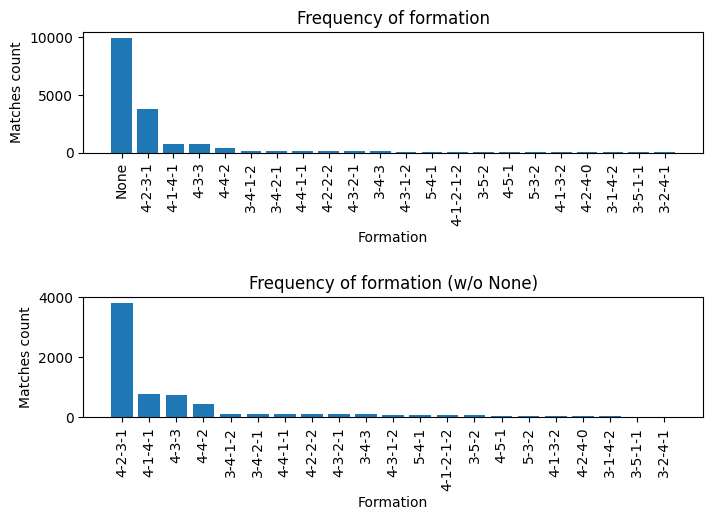

In [8]:
df_tmp1 = df_brt_full.groupby("formacao_mandante").count().withColumnRenamed("formacao_mandante", "formacao")
df_tmp2 = df_brt_full.groupby("formacao_visitante").count().withColumnRenamed("formacao_visitante", "formacao")


df_tmp = df_tmp1.union(df_tmp2).groupby("formacao").sum().toPandas().sort_values('sum(count)', ascending=False)

df_tmp_full = df_tmp.fillna('None')
df_tmp_partial = df_tmp.dropna()

fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(8, 5))

axs[0].bar(df_tmp_full['formacao'], df_tmp_full['sum(count)'])
axs[0].set_xticklabels(df_tmp_full['formacao'], rotation=90)
axs[0].set_title('Frequency of formation')
axs[0].set_ylabel('Matches count')
axs[0].set_xlabel('Formation')

axs[1].bar(df_tmp_partial['formacao'], df_tmp_partial['sum(count)'])
axs[1].set_xticklabels(df_tmp_partial['formacao'], rotation=90)
axs[1].set_title('Frequency of formation (w/o None)')
axs[1].set_ylabel('Matches count')
axs[1].set_xlabel('Formation')

fig.subplots_adjust(hspace=1.2)

plt.show()



It seems that the *formation* column (formacao_*) contains a lot of N/A values. Let's check and compare the count of None values vs the rest:

Text(0.5, 0, 'Formation value')

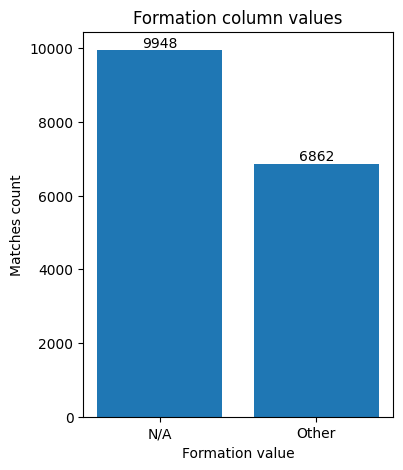

In [9]:
df_tmp_full = df_tmp.fillna('None')
df_tmp_full['formacao'] = df_tmp_full['formacao'].apply(lambda x: 'N/A' if x == 'None' else 'Other')

df_tmp_cnt = df_tmp_full.groupby("formacao").sum().reset_index()

#y1 = df_tmp_cnt[df_tmp_cnt['formacao'] == 'None']
#y2 = df_tmp_cnt[df_tmp_cnt['formacao'] == 'Other']
#plt.bar(np.array(['formacao']), y1['sum(count)'], color='grey')
#plt.bar(np.array(['formacao']), y2['sum(count)'], color='darkblue')

fig, ax = plt.subplots(figsize=(4, 5))
bars = plt.bar(df_tmp_cnt['formacao'], df_tmp_cnt['sum(count)'])
ax.bar_label(bars)
ax.set_title('Formation column values')
ax.set_ylabel('Matches count')
ax.set_xlabel('Formation value')

Most of the values for the *formation* column contains N/A data, which will make us reduce the datased discarding these rows, or this field may not be be very discriminative.

##2.3) Coaches

It seems that here we also have a high proportion of N/As in the *coach* columns (tecnico_*)

In [10]:
df_tmp1 = df_brt_full.groupby("tecnico_mandante").count().withColumnRenamed("tecnico_mandante", "tecnico")
df_tmp2 = df_brt_full.groupby("tecnico_visitante").count().withColumnRenamed("tecnico_visitante", "tecnico")

df_tmp = df_tmp1.union(df_tmp2).groupby("tecnico").sum().toPandas().sort_values('sum(count)', ascending=False)
df_tmp = df_tmp.fillna('None')

df_tmp_cnt = df_tmp.copy()
df_tmp_cnt['tecnico'] = df_tmp_cnt['tecnico'].apply(lambda x: x if x == 'None' else 'Other')
df_tmp_cnt = df_tmp_cnt.groupby("tecnico").sum().reset_index()

df_tmp_cnt

,tecnico,sum(count)
0,None,9220
1,Other,7590


In [11]:
coaches_lst = pd.unique(df_tmp['tecnico'])
n_coach = 10
print(f"We have {len(coaches_lst)} unique coach names")
print(f"Top {n_coach} list:")
df_tmp.iloc[1:1+n_coach]

We have 242 unique coach names
Top 10 list:


,tecnico,sum(count)
155,L. Venker de Menezes,261
211,V. Carmo Mancini,251
80,Renato Gaúcho,223
145,D. Silvestre Júnior,203
132,A. Stival,202
140,J. Ribeiro Ventura,176
87,E. Baptista,162
213,A. Ferreira,159
173,F. Diniz Silva,159
126,E. Alves Moreira,158


##2.4) Stadiums and locations

In [12]:
df_tmp = df_brt_full.groupby("arena").count().toPandas().sort_values('count', ascending=False)
df_tmp = df_tmp.fillna('None')

df_tmp

,arena,count
141,Maracanã,631
26,Mineirão,459
25,Morumbi,413
126,Couto Pereira,295
135,Serra Dourada,235
...,...,...
109,R de Oliveira*(PF),1
112,Bruno J.Daniel (*PF),1
113,Olímpico Engenhão,1
114,Estádio Joaquim Henrique Nogueira-Arena do jacaré,1


Here the problem isn't the excessive presence of N/A values, but the extreme diversification of possible values for the field - 162 total.

Let's plot a ranking with most frequent venues

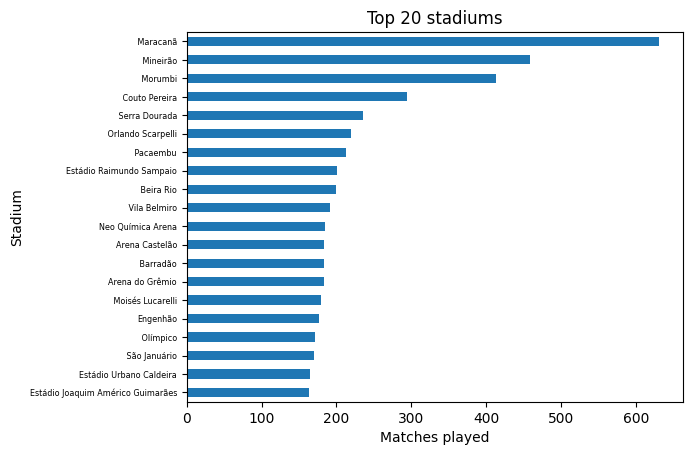

In [13]:
# Plot match stadiums distribution
n_stadiums = 20
df_tmp = df_brt_full.groupby("arena").count().toPandas().sort_values('count', ascending=False)
df_tmp = df_tmp.iloc[0:n_stadiums].sort_values('count', ascending=True)
df_tmp.plot.barh(x='arena', y='count', legend=False)

plt.ylabel('Stadium')
plt.xlabel('Matches played')
plt.title(f'Top {n_stadiums} stadiums')
plt.yticks(fontsize = 'xx-small')
plt.show()

State of origin of each team is a simple field, with only 27 possible values maximum. In practice, only some are present in the first division championship.

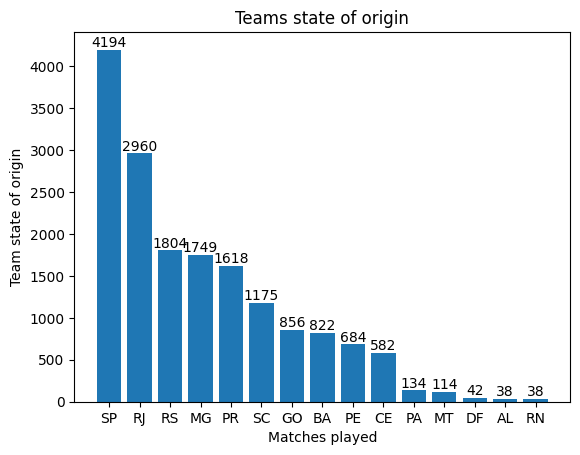

In [14]:
# Plot team states of origin distribution
df_tmp1 = df_brt_full.groupby("mandante_Estado").count().withColumnRenamed("mandante_Estado", "estado")
df_tmp2 = df_brt_full.groupby("visitante_Estado").count().withColumnRenamed("visitante_Estado", "estado")
df_tmp = df_tmp1.union(df_tmp2).groupby("estado").sum().toPandas().sort_values('sum(count)', ascending=False)

fig, ax = plt.subplots()
#df_tmp.plot.bar(x='estado', y='sum(count)', legend=False)
bars = plt.bar(df_tmp['estado'], df_tmp['sum(count)'])
plt.ylabel('Team state of origin')
plt.xlabel('Matches played')
plt.title(f'Teams state of origin')
ax.bar_label(bars)
plt.show()

##2.5) Match scores

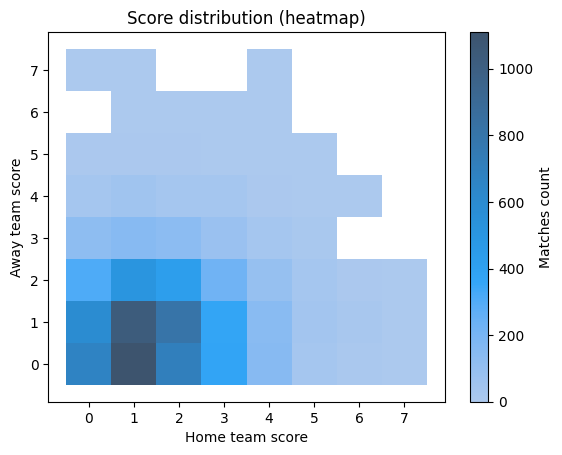

In [15]:
# Plot match scores heatmap
df_tmp = df_brt_full.select(['mandante_Placar', 'visitante_Placar']).toPandas()

ax = sns.histplot(data=df_tmp, x="mandante_Placar", y="visitante_Placar",  discrete=True, cbar=True, cbar_kws={'label': 'Matches count'})
ax.set_title('Score distribution (heatmap)')
ax.set_ylabel('Away team score')
ax.set_xlabel('Home team score')
plt.show()

##2.5) Match final result and other adjustments

First adjustments are date and time formatting. Also, we add the target column containing the match result at each row.

**W: home team won**

**L: home team lost**

**D: draw**

In [16]:

# Adjust 'hora' (timestamp) field
df_brt_full = df_brt_full.withColumn("hora_tmp", date_format(df_brt_full["hora"], "HH:mm:ss")).drop("hora")
df_brt_full = df_brt_full.withColumn("hora", df_brt_full["hora_tmp"]).drop("hora_tmp")
df_brt_full = df_brt_full.orderBy("ID")

# Calculate all possible teams
teams_list = [row['mandante'] for row in df_brt_full.select('mandante').distinct().collect()]
teams_list += [row['visitante'] for row in df_brt_full.select('visitante').distinct().collect()]
teams_list = list(set(teams_list))

# Adds result column
# W: mandante won L: visitante won D: draw
df_brt_full = df_brt_full.withColumn("result",  when(col('vencedor') == col('mandante') , "W").otherwise(when(col('vencedor') == col('visitante') , "L").otherwise("D")))
invert_result = lambda x: "L" if x == "W" else ("W" if x == "L" else x)

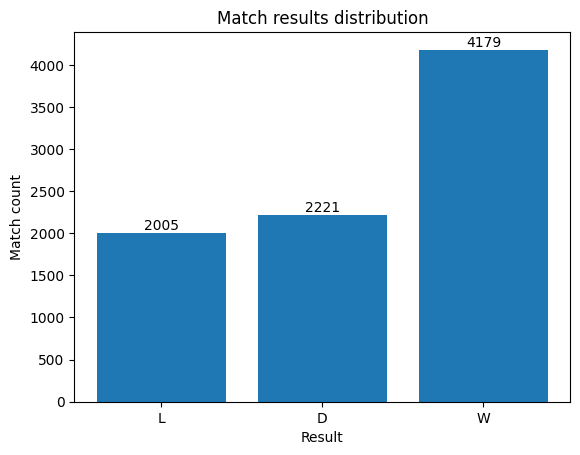

In [17]:
# Plot match results distribution

df_tmp = df_brt_full.groupby("result").count().toPandas()

fig, ax = plt.subplots()
#df_tmp.plot.bar(x='estado', y='sum(count)', legend=False)
bars = plt.bar(df_tmp['result'], df_tmp['count'])
plt.title('Match results distribution')
plt.xlabel('Result')
plt.ylabel('Match count')
ax.bar_label(bars)
plt.show()

#3) Feature Generation

#3.1) Series of past results

Past goals scored, conceded and final result of the *overall* last Np matches of home and away team

In [18]:
Np = 5
np_digits = len(str(Np))
column_suffix = lambda p : "d" + str(p).zfill(np_digits)

col_scored_mandante = []
col_scored_visitante = []
col_against_mandante = []
col_against_visitante = []
col_results_mandante = []
col_results_visitante = []

header_scored_mandante = ["ID"] + ["scored_mandante_" + column_suffix(i) for i in range(1,Np+1)]
header_scored_visitante = ["ID"] + ["scored_visitante_" + column_suffix(i) for i in range(1,Np+1)]
header_against_mandante = ["ID"] + ["against_mandante_" + column_suffix(i) for i in range(1,Np+1)]
header_against_visitante = ["ID"] + ["against_visitante_" + column_suffix(i) for i in range(1,Np+1)]
header_results_mandante = ["ID"] + ["results_mandante_" + column_suffix(i) for i in range(1,Np+1)]
header_results_visitante = ["ID"] + ["results_visitante_" + column_suffix(i) for i in range(1,Np+1)]


last_scored = defaultdict(lambda:Np*[None])
last_against = defaultdict(lambda:Np*[None])
last_results = defaultdict(lambda:Np*[None])

# Loop over the rows
for row in df_brt_full.collect():

    team1 = row['mandante']
    team1_scored = last_scored[team1]
    team1_against = last_against[team1]
    team1_results = last_results[team1]

    team2 = row['visitante']
    team2_scored = last_scored[team2]
    team2_against = last_against[team2]
    team2_results = last_results[team2]

    col_scored_mandante.append(tuple([row["ID"]] + team1_scored))
    col_scored_visitante.append(tuple([row["ID"]] + team2_scored))
    col_against_mandante.append(tuple([row["ID"]] + team1_against))
    col_against_visitante.append(tuple([row["ID"]] + team2_against))
    col_results_mandante.append(tuple([row["ID"]] + team1_results))
    col_results_visitante.append(tuple([row["ID"]] + team2_results))

    team1_scored = [row['mandante_Placar']] + team1_scored[:-1]
    team2_scored = [row['visitante_Placar']] + team2_scored[:-1]
    team1_against = [row['visitante_Placar']] + team1_against[:-1]
    team2_against = [row['mandante_Placar']] + team2_against[:-1]
    team1_results = [row['result']] + team1_results[:-1]
    team2_results = [invert_result(row['result'])] + team2_results[:-1]

    last_scored[team1] = team1_scored
    last_scored[team2] = team2_scored
    last_against[team1] = team1_against
    last_against[team2] = team2_against
    last_results[team1] = team1_results
    last_results[team2] = team2_results


df_scored_mandante = spark.createDataFrame(col_scored_mandante, header_scored_mandante)
df_scored_visitante = spark.createDataFrame(col_scored_visitante, header_scored_visitante)
df_against_mandante = spark.createDataFrame(col_against_mandante, header_against_mandante)
df_against_visitante = spark.createDataFrame(col_against_visitante, header_against_visitante)
df_results_mandante = spark.createDataFrame(col_results_mandante, header_results_mandante)
df_results_visitante = spark.createDataFrame(col_results_visitante, header_results_visitante)



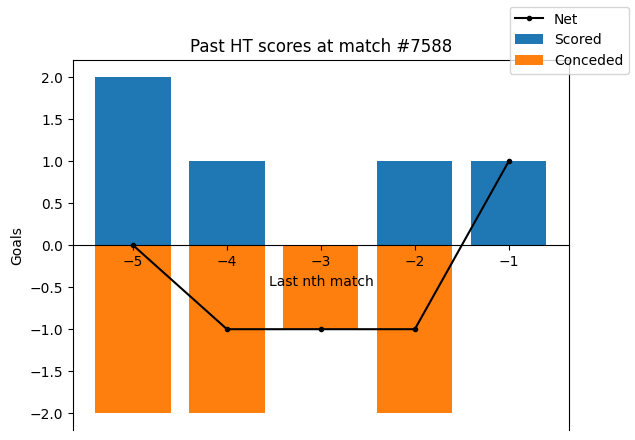

Result at the current match (n=0) was W


In [19]:
#Plot one sample
df_tmp_a = df_scored_mandante.toPandas()
df_tmp_b = df_against_mandante.toPandas()
x = np.array(range(-1, -Np-1, -1))

# First samples will tend to have N/A values
# thus we start the sampling from a point away from the begining
sample_n = random.randint(100, df_tmp_a.shape[0]-1)
sample_row_a = df_tmp_a.iloc[sample_n]
sample_row_b = df_tmp_b.iloc[sample_n]

ya = sample_row_a.iloc[1:].to_numpy(dtype=np.int32)
yb = - sample_row_b.iloc[1:].to_numpy(dtype=np.int32)
yr = ya + yb

df_plot_a = pd.DataFrame({'x': x, 'y': ya})
df_plot_b = pd.DataFrame({'x': x, 'y': yb})
df_plot_r = pd.DataFrame({'x': x, 'y': yr})

fig, ax1 = plt.subplots()

plt.bar(x, ya)
plt.bar(x, yb)
plt.plot(x, yr, color='black', marker='.')

ax1.spines['bottom'].set_position('zero')
plt.title(f'Past HT scores at match #{sample_n}')
plt.xlabel('Last nth match')
plt.ylabel('Goals')

fig.legend(labels=['Net','Scored','Conceded'])

plt.show()

sample_id = sample_row_a["ID"]
sample_result = df_brt_full[df_brt_full["ID"]==sample_id].toPandas()['result'].values[0]

print(f"Result at the current match (n=0) was {sample_result}")

Now we calculate past scored, conceded and final result of the past Nv matches between home and away teams. Note that this is different from previous features - i.e. includes only last matches between the two teams in question.

In [20]:
Nv = 3
nv_digits = len(str(Nv))
column_suffix = lambda v : "d" + str(v).zfill(nv_digits)

col_scored_past = []
col_against_past = []
col_results_past = []

header_scored_past = ["ID"] + ["scored_past_" + column_suffix(i) for i in range(1,Nv+1)]
header_against_past = ["ID"] + ["against_past_" + column_suffix(i) for i in range(1,Nv+1)]
header_results_past = ["ID"] + ["results_past_" + column_suffix(i) for i in range(1,Nv+1)]

last_scored = defaultdict(lambda:defaultdict(lambda:Nv*[None]))
last_results = defaultdict(lambda:defaultdict(lambda:Nv*[None]))

# Loop over the rows
for row in df_brt_full.collect():

    team1 = row['mandante']
    team2 = row['visitante']

    team1_scored = last_scored[team1][team2]
    team2_scored = last_scored[team2][team1]
    team1_results = last_results[team1][team2]
    team2_results = last_results[team2][team1]

    col_scored_past.append(tuple([row["ID"]] + team1_scored))
    col_against_past.append(tuple([row["ID"]] + team2_scored))
    col_results_past.append(tuple([row["ID"]] + team1_results))

    team1_scored = [row['mandante_Placar']] + team1_scored[:-1]
    team2_scored = [row['visitante_Placar']] + team2_scored[:-1]

    team1_results = [row['result']] + team1_results[:-1]
    team2_results = [invert_result(row['result'])] + team2_results[:-1]

    last_scored[team1][team2] = team1_scored
    last_scored[team2][team1] = team2_scored
    last_results[team1][team2] = team1_results
    last_results[team2][team1] = team2_results

df_scored_past = spark.createDataFrame(col_scored_past, header_scored_past)
df_against_past = spark.createDataFrame(col_against_past, header_against_past)
df_results_past = spark.createDataFrame(col_results_past, header_results_past)

Now we join the newly calculated features

In [21]:


df_data = df_brt_full.select(['ID', 'result', 'data', 'hora', 'mandante', 'visitante', 'formacao_mandante', 'formacao_visitante', 'tecnico_mandante', 'tecnico_visitante', 'arena', 'mandante_Estado', 'visitante_Estado'])

# Adds newly generated columns
df_data = df_data.join(df_scored_mandante, on="ID", how="full")
df_data = df_data.join(df_scored_visitante, on="ID", how="full")
df_data = df_data.join(df_against_mandante, on="ID", how="full")
df_data = df_data.join(df_against_visitante, on="ID", how="full")
df_data = df_data.join(df_results_mandante, on="ID", how="full")
df_data = df_data.join(df_results_visitante, on="ID", how="full")
df_data = df_data.join(df_scored_past, on="ID", how="full")
df_data = df_data.join(df_against_past, on="ID", how="full")
df_data = df_data.join(df_results_past, on="ID", how="full")

#df_data = df_data.drop("ID")


# Adds columns names to feature list
# Results are encoded later
features_cols += [c for c in header_scored_mandante if c != "ID"]
features_cols += [c for c in header_scored_visitante if c != "ID"]
features_cols += [c for c in header_against_mandante if c != "ID"]
features_cols += [c for c in header_against_visitante if c != "ID"]
features_cols += [c for c in header_results_mandante if c != "ID"]
features_cols += [c for c in header_results_visitante if c != "ID"]
features_cols += [c for c in header_scored_past if c != "ID"]
features_cols += [c for c in header_against_past if c != "ID"]
features_cols += [c for c in header_results_past if c != "ID"]



In [22]:
f_n_count = 0
f_n_count += len(header_scored_mandante) - 1
f_n_count += len(header_scored_visitante) - 1
f_n_count += len(header_against_mandante) - 1
f_n_count += len(header_against_visitante) - 1
f_n_count += len(header_results_mandante) - 1
f_n_count += len(header_results_visitante) - 1
f_n_count += len(header_scored_past) - 1
f_n_count += len(header_against_past) - 1
f_n_count += len(header_results_past) - 1

print(f"We added {f_n_count} features")

We added 39 features


# 4) Feature encoding

We now just encode categorical features for appropriate model training

##4.1) Encoding date/time

Just separates year, month, day, hour, into different columns

In [23]:
#df_data = df_data.select(dayofweek('data').alias('dayweek'))
#df_data = df_data.withColumn("dayweek", dayofweek(df_data["data"])

df_data = df_data.withColumn("convdate", to_date(df_data["data"], "dd/MM/yyyy"))
df_data = df_data.withColumn("date_dayweek", dayofweek(df_data["convdate"]))
df_data = df_data.withColumn("date_day", dayofmonth(df_data["convdate"]))
df_data = df_data.withColumn("date_month", month(df_data["convdate"]))
df_data = df_data.withColumn("date_year", year(df_data["convdate"]))
df_data = df_data.withColumn("date_time", hour(df_data["hora"])*100 + minute(df_data["hora"]))


df_data = df_data.drop('data')
df_data = df_data.drop('convdate')
df_data = df_data.drop('hora')

# We choose not to use those features for now
#features_cols += ['date_dayweek','date_day', 'date_month', 'date_year', 'date_time']


##4.2) Encoding team names

I tried some encoding methods for team names - indexing, one-hot, and a custom vector encoding. In the end, I choose to use **one-hot** encoding here.

In [24]:
# Create encoder from team list
df_teams_base = spark.createDataFrame([[t] for t in teams_list], ["team"])

enc1 = StringIndexer(inputCol="team", outputCol="team_index")
enc2 = OneHotEncoder(dropLast=False, inputCol="team_index", outputCol="team_encoded")

team_encoder = Pipeline(stages=[enc1, enc2]).fit(df_teams_base)

# Convert teams from dataframe

df_team1 = df_data.select(['ID', 'mandante']).withColumnRenamed("mandante", "team")
df_team2 = df_data.select(["ID", "visitante"]).withColumnRenamed("visitante", "team")

df_team1_enc = team_encoder.transform(df_team1).withColumnRenamed("team_encoded", "home_team").withColumnRenamed("team_index", "home_team_index").drop("team")
df_team2_enc = team_encoder.transform(df_team2).withColumnRenamed("team_encoded", "away_team").withColumnRenamed("team_index", "away_team_index").drop("team")

df_matches = df_team1_enc.join(df_team2_enc, on="ID", how="inner")


# Combine team vectors using weighted sum

def combine_teams(t1, t2, w=2.0):
    t1_v = t1.toArray()
    t2_v = t2.toArray()
    res = w*t1_v + t2_v
    vec_args =  len(res), [(i, val) for i, val in enumerate(res) if val != 0]
    return Vectors.sparse(*vec_args)

combine_teams_udf = udf(combine_teams, VectorUDT())
df_matches = df_matches.withColumn("teams_w", combine_teams_udf(col('home_team'), col('away_team')))

# Combine team vectors using concatenation

team_assembler = VectorAssembler(inputCols=['home_team', 'away_team'], outputCol='teams_c')
df_matches = team_assembler.transform(df_matches)


# Drop unused encodings - LEAVE AT LEAST ONE
#df_matches = df_matches.drop("home_team").drop("away_team")
#df_matches = df_matches.drop("home_team_index").drop("away_team_index")
df_matches = df_matches.drop("teams_w")
df_matches = df_matches.drop("teams_c")

# Join into original dataframe
df_data = df_data.join(df_matches, on="ID", how="inner")
#features_cols += [c for c in df_matches.columns if c != "ID"]
features_cols += ['home_team', 'away_team']

# Drop old columns
df_data = df_data.drop("mandante")
df_data = df_data.drop("visitante")


df_data = df_data.orderBy("ID")

##4.3) Encode other categorical features + target

Here we encode all other features + target column using one-hot and simple integer indexing. For the final modelling, we chose to use only **integer indexing** here.

In [25]:

features_cat = ['formacao_mandante', 'formacao_visitante', 'tecnico_mandante', 'tecnico_visitante']
features_cat += ['arena', 'mandante_Estado', 'visitante_Estado']

features_cat_idx = [f + "_index" for f in features_cat]
#features_cat_idx = [f + "_enc" for f in features_cat]
features_cat_enc = [f + "_enc" for f in features_cat]


df_data.na.drop(subset=features_cat)


encoders_list = []

for f_c, f_i in zip(features_cat, features_cat_idx):
    enc_i = StringIndexer(inputCol=f_c, outputCol=f_i, handleInvalid='keep')
    encoders_list = encoders_list + [enc_i]

for f_i, f_e in zip(features_cat_idx, features_cat_enc):
    enc_e = OneHotEncoder(dropLast=False, inputCol=f_i, outputCol=f_e, handleInvalid='keep')
    encoders_list = encoders_list + [enc_e]

features_cat_encoder = Pipeline(stages=encoders_list).fit(df_data)
df_data = features_cat_encoder.transform(df_data)

df_data = df_data.drop(*features_cat)
#df_data = df_data.drop(*features_cat_idx)

# Chosen method with best trade off between accuracy and complexity
features_cols += features_cat_idx

In [26]:
# Encode results (W/L/D) into indexes

results_cols = [c for c in df_data.columns if c.find("results") != -1]

def convert_result(r):
    if r == "W":
        return 2
    if r == "L":
        return 1
    if r == "D":
        return 0
    return r

#def convert_result(r):
#    ret = np.asarray([0, 0])
#    if r == "W":
#        np.asarray([1, 0])
#    if r == "L":
#        np.asarray([0, 1])
#    vec_args =  len(ret), [(i, val) for i, val in enumerate(ret) if val != 0]
#    return Vectors.sparse(*vec_args)

convert_result_udf = udf(convert_result, IntegerType())

df_results_enc = df_data.select(["ID"] + results_cols)

for c in results_cols:

    df_results_enc = df_results_enc.withColumn(c + "_enc", convert_result_udf(c))
    df_results_enc = df_results_enc.drop(c)
    df_data = df_data.drop(c)
    df_results_enc = df_results_enc.withColumnRenamed(c + "_enc", c)


df_data = df_data.join(df_results_enc, on="ID", how="inner")
#df_data = df_data.drop(*results_cols)




In [27]:
# Also encode target col

df_data = df_data.withColumn("result_enc", convert_result_udf("result"))

#tenc1 = StringIndexer(inputCol="result", outputCol="result_index")
#tenc2 = OneHotEncoder(dropLast=False, inputCol="result_index", outputCol="result_vec")
#target_encoder = Pipeline(stages=[tenc1, tenc2]).fit(df_data)
#df_data = df_data.drop("result_index")

df_data = df_data.drop("result")
df_data = df_data.withColumnRenamed("result_enc", "result")

## 4.4) Final adjustments


After some testing, we achieved good results simply dropping all rows containing N/A values

In [28]:
# Drop NULL/NA values

df_data = df_data.na.drop()
#df_data = df_data.drop("ID")
#df_data = df_data.drop(*features_cat_enc)

In [29]:
print(f"The final dataframe contains {df_data.count()} samples")

The final dataframe contains 6356 samples


And finally, for pyspark model training, we assemble a **feature vector column** containing all the features we selected previously

In [30]:
# Asembly feature column
#features_cols = [c for c in df_data.columns if c != target_column and c != "ID"]
#features_cols = ['home_team', 'away_team', 'result']

final_assembler = VectorAssembler(inputCols=features_cols, outputCol=features_vec_col)
df_data = final_assembler.transform(df_data)

#df_data = df_data.drop(*data_cols)

In [31]:
df_data.show()

+----+------------------+------------------+------------------+------------------+------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------+--------------+--------------+---------------+---------------+---------------+------------+--------+----------+---------+---------+---------------+---------------+---------------+---------------+-----------------------+------------------------+----------------------+-----------------------+-----------+---------------------+----------------------+---------------------+----------------------+--------------------+---------------------+----------------+-------------------+--------------------+-------------------+-------------------+-------------------+-------------------+-----

Let's check the distribution of the results of the final dataframe:

In [32]:
df_data.groupby("result").count().show()

+------+-----+
|result|count|
+------+-----+
|     1| 1557|
|     2| 3134|
|     0| 1665|
+------+-----+



These are the resulting features that will be used in the modelling process

In [33]:
print(*features_cols, sep='\n')

scored_mandante_d1
scored_mandante_d2
scored_mandante_d3
scored_mandante_d4
scored_mandante_d5
scored_visitante_d1
scored_visitante_d2
scored_visitante_d3
scored_visitante_d4
scored_visitante_d5
against_mandante_d1
against_mandante_d2
against_mandante_d3
against_mandante_d4
against_mandante_d5
against_visitante_d1
against_visitante_d2
against_visitante_d3
against_visitante_d4
against_visitante_d5
results_mandante_d1
results_mandante_d2
results_mandante_d3
results_mandante_d4
results_mandante_d5
results_visitante_d1
results_visitante_d2
results_visitante_d3
results_visitante_d4
results_visitante_d5
scored_past_d1
scored_past_d2
scored_past_d3
against_past_d1
against_past_d2
against_past_d3
results_past_d1
results_past_d2
results_past_d3
home_team
away_team
formacao_mandante_index
formacao_visitante_index
tecnico_mandante_index
tecnico_visitante_index
arena_index
mandante_Estado_index
visitante_Estado_index


In [34]:
features_count = df_data.schema[features_vec_col].metadata["ml_attr"]["num_attrs"]
print(f'Number of features after vectorization {features_count}')

Number of features after vectorization 136


## 4.5) Dataset splitting

In [35]:

train_fraction = 0.7
val_fraction = (1-train_fraction)
seed = 21


#data_cut = df_data.select(percentile_approx('ID', 0.7))
#data_cut = 6268 #70% of ID
#df_train = df_data.filter(df_data.ID <= data_cut)
#df_val = df_data.filter(df_data.ID > data_cut)

df_train, df_val = df_data.randomSplit([train_fraction, val_fraction], seed=seed)

In [36]:
print(df_train.count(), df_val.count())

4419 1937


#5) Model Training and Evaluation

There are several possibilities to be explored here. For this project, we tested 3 models, using a One-vs-Rest approach: Multilayer Perceptron, Gradient Boost Classifer and Random Forest

##5.2) Multilayer Perceptron model

In [37]:
# Multilayer Perceptron model

layers_list = [features_count, 64, 32, 3]

model_mp = MultilayerPerceptronClassifier(layers=layers_list, featuresCol=features_vec_col, labelCol=target_col, seed=21)
#model_ovrb = OneVsRest(classifier=model_mp, labelCol=target_col, featuresCol=features_vec_col)
model_ovrb = model_mp

cl_model1 = model_ovrb.fit(df_train)

In [38]:
preds1_train = cl_model1.transform(df_train)
preds1_val = cl_model1.transform(df_val)

# Select (prediction, true label) and compute test error
evaluator = MulticlassClassificationEvaluator(labelCol=target_col, predictionCol="prediction", metricName="accuracy")

acc_train1 = evaluator.evaluate(preds1_train)
acc_val1 = evaluator.evaluate(preds1_val)

print("Accuracy train = %g" % (acc_train1))
print("Accuracy val = %g" % (acc_val1))

Accuracy train = 0.506676
Accuracy val = 0.484254


In [39]:
preds1_val.groupby("result").count().show()

+------+-----+
|result|count|
+------+-----+
|     1|  453|
|     2|  931|
|     0|  553|
+------+-----+



##5.2) Gradient Boost Classifier

In [40]:
# One-vs-rest Gradient Boost model

model_gbt = GBTClassifier(labelCol=target_col, featuresCol=features_vec_col, maxBins=256)
model_ovr = OneVsRest(classifier=model_gbt, labelCol=target_col, featuresCol=features_vec_col)

cl_model2 = model_ovr.fit(df_train)

In [41]:
preds2_train = cl_model2.transform(df_train)
preds2_val = cl_model2.transform(df_val)

# Select (prediction, true label) and compute test error
evaluator = MulticlassClassificationEvaluator(labelCol=target_col, predictionCol="prediction", metricName="accuracy")

acc_train2 = evaluator.evaluate(preds2_train)
acc_val2 = evaluator.evaluate(preds2_val)

print("Accuracy train = %g" % (acc_train2))
print("Accuracy val = %g" % (acc_val2))

Accuracy train = 0.681376
Accuracy val = 0.670625


In [42]:
preds2_val.groupby("prediction").count().show()

+----------+-----+
|prediction|count|
+----------+-----+
|       0.0|  283|
|       1.0|  273|
|       2.0| 1381|
+----------+-----+



##5.3) Random Forest model

This is the model that achieved the best results

In [43]:
# Random forest model

model_rf = RandomForestClassifier(featuresCol=features_vec_col, labelCol=target_col, maxBins=256, maxDepth=25, numTrees=128)
model_ovra = OneVsRest(classifier=model_rf, labelCol=target_col, featuresCol=features_vec_col)

cl_model3 = model_ovra.fit(df_train)


Now we evaluate the model against training and test datasets

In [44]:
preds3_train = cl_model3.transform(df_train)
preds3_val = cl_model3.transform(df_val)

# Select (prediction, true label) and compute test error
evaluator = MulticlassClassificationEvaluator(labelCol=target_col, predictionCol="prediction", metricName="accuracy")

acc_train3 = evaluator.evaluate(preds3_train)
acc_val3 = evaluator.evaluate(preds3_val)

print("Accuracy train = %g" % (acc_train3))
print("Accuracy val = %g" % (acc_val3))

Accuracy train = 0.847251
Accuracy val = 0.84254


We achieved near 85% accuracy on the test set. Good result for this kind of project.

In [45]:
preds3_val.groupby("prediction").count().show()

+----------+-----+
|prediction|count|
+----------+-----+
|       0.0|  407|
|       1.0|  367|
|       2.0| 1163|
+----------+-----+



##5.4) Vizualization of results

Based on accuracy, we can say that the Random Forest model achieved the best results.

Text(0.5, 0, 'Model')

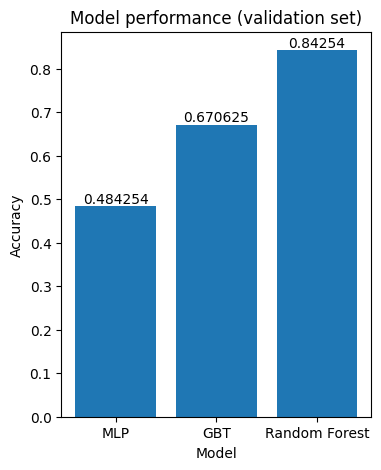

In [46]:
models_names = ["MLP", "GBT", "Random Forest"]
acc_vals = [acc_val1, acc_val2, acc_val3]

fig, ax = plt.subplots(figsize=(4, 5))
bars = plt.bar(models_names, acc_vals)
ax.bar_label(bars)
ax.set_title('Model performance (validation set)')
ax.set_ylabel('Accuracy')
ax.set_xlabel('Model')

Let's see with more detail the results of the chosen model. For this task, we will plot a confusion matrix.

In [47]:

preds3_val_rdd = preds3_val.select('result', 'prediction').rdd

preds3_vals = preds3_val_rdd.map(lambda x: (float(x[0]), float(x[1])))

preds3_metrics = MulticlassMetrics(preds3_vals)

preds3_cmat = preds3_metrics.confusionMatrix().toArray()

/content/spark-3.5.1-bin-hadoop3/python/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


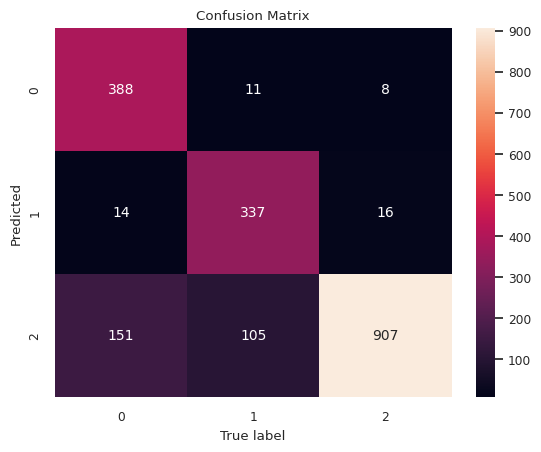

In [48]:
# Plot the confusion Matrix

df_cm = pd.DataFrame(preds3_cmat, range(3), range(3))
# plt.figure(figsize=(10,7))
sns.set(font_scale=0.8) # for label size
sns.heatmap(df_cm, annot=True, annot_kws={"size": 10}, fmt='.0f') # font size

plt.xlabel("True label")
plt.ylabel("Predicted")
plt.title("Confusion Matrix")

plt.show()

Remember the final indexing used:


Win: 2

Draw: 1

Loss: 0

Considering that soccer matches are essentially hard to predict, I believe this project achieved interesting results. Also, we passed trought all the steps expected from a Machine Learning project, which was really useful for learning purposes.
